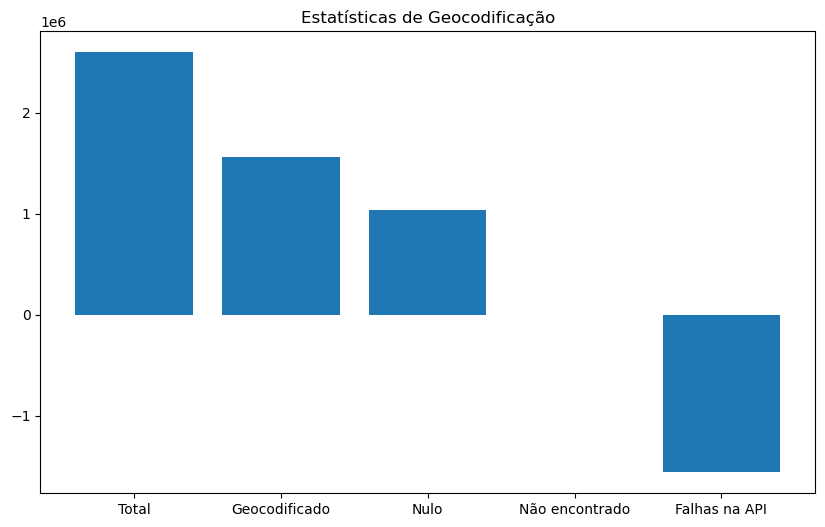

In [4]:
import os  # Adicionando a importação do módulo os
import pandas as pd
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut, GeocoderUnavailable
import time
import json
import threading
import matplotlib.pyplot as plt

# Configurações
data_input = 'Dados_2015_filtrados_limpos.csv'
data_output = 'Dados_2015_filtrados_limpos_emi_des.csv'
cache_file = 'geocode_cache.json'
address_columns = ['BAIRRO_EMI', 'CEP_EMI', 'MUNICIPIO_EMI', 'UF_EMI']
lat_column = 'latitude_emi'
lon_column = 'longitude_emi'
country = 'Brazil'
MAX_TRIES = 2
THREADS = 5
time_trie = 2

# Carregar ou inicializar o cache
try:
    with open(cache_file, 'r') as f:
        geocode_cache = json.load(f)
except (FileNotFoundError, json.JSONDecodeError):
    geocode_cache = {}

# Função para geocodificar endereços
def geocode_address(address):
    geolocator = Nominatim(user_agent="geoapiExercises")
    try:
        return geolocator.geocode(address, timeout=10)
    except (GeocoderTimedOut, GeocoderUnavailable):
        return None

# Função para geocodificar e atualizar linhas
def geocode_and_update_rows(df_chunk):
    for index, row in df_chunk.iterrows():
        if pd.notnull(row[lat_column]) and pd.notnull(row[lon_column]):
            continue

        address_key = str(tuple(row[col] for col in address_columns))
        if address_key in geocode_cache:
            lat, lon = geocode_cache[address_key]
        else:
            time.sleep(1)  # Atraso para cada requisição
            address = f"{', '.join(str(row[col]) for col in address_columns)}, {country}"
            for attempt in range(MAX_TRIES):
                location = geocode_address(address)
                if location:
                    lat, lon = location.latitude, location.longitude
                    geocode_cache[address_key] = (lat, lon)
                    break
                time.sleep(time_trie)
            else:
                lat, lon = None, None
                geocode_cache[address_key] = (lat, lon)

        df.at[index, lat_column] = lat
        df.at[index, lon_column] = lon

# Dividir DataFrame e iniciar threads
def start_geocoding_threads(df):
    chunk_size = len(df) // THREADS
    threads = []
    for i in range(THREADS):
        start = i * chunk_size
        end = None if i == THREADS - 1 else (i + 1) * chunk_size
        df_chunk = df.iloc[start:end]
        t = threading.Thread(target=geocode_and_update_rows, args=(df_chunk,))
        threads.append(t)
        t.start()

    for t in threads:
        t.join()

# Carregar dados e iniciar processamento
df = pd.read_csv(data_output if os.path.exists(data_output) else data_input)
if lat_column not in df.columns or lon_column not in df.columns:
    df[lat_column] = None
    df[lon_column] = None

start_geocoding_threads(df)

# Salvar os resultados
df.to_csv(data_output, index=False)
with open(cache_file, 'w') as f:
    json.dump(geocode_cache, f)

# Gerar e mostrar gráficos finais
generate_summary_graphs(df)

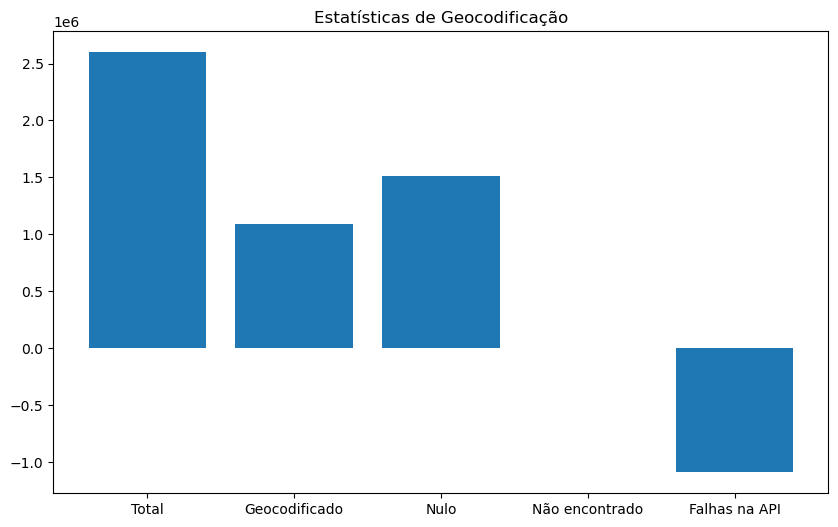

In [5]:
import os  # Adicionando a importação do módulo os
import pandas as pd
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut, GeocoderUnavailable
import time
import json
import threading
import matplotlib.pyplot as plt

# Configurações
data_input = 'Dados_2015_filtrados_limpos.csv'
data_output = 'Dados_2015_filtrados_limpos_emi_des.csv' # Se for mantido fixo, ele continua de onde parou caso tenha algum problema
cache_file = 'geocode_cache.json'
address_columns = ['BAIRRO_DES', 'CEP_DES', 'MUNICIPIO_DES', 'UF_DES'] # Referente as colunas de endereços a serem usadas
# Referente as colunas de destino do geocode
lat_column = 'latitude_des'
lon_column = 'longitude_des'
country = 'Brazil'
MAX_TRIES = 2 # Quantidade de vezes que o codigo deve tentar geocoficar cada endereço caso falhe
THREADS = 5 # Quantidade de threads que rodam em paralelo para geocodificar
time_trie = 2 # Tempo entre cada tentativa de geocodificação

# Carregar ou inicializar o cache
try:
    with open(cache_file, 'r') as f:
        geocode_cache = json.load(f)
except (FileNotFoundError, json.JSONDecodeError):
    geocode_cache = {}

# Função para geocodificar endereços
def geocode_address(address):
    geolocator = Nominatim(user_agent="geoapiExercises")
    try:
        return geolocator.geocode(address, timeout=10)
    except (GeocoderTimedOut, GeocoderUnavailable):
        return None

# Função para geocodificar e atualizar linhas
def geocode_and_update_rows(df_chunk):
    for index, row in df_chunk.iterrows():
        if pd.notnull(row[lat_column]) and pd.notnull(row[lon_column]):
            continue

        address_key = str(tuple(row[col] for col in address_columns))
        if address_key in geocode_cache:
            lat, lon = geocode_cache[address_key]
        else:
            time.sleep(1)  # Atraso para cada requisição
            address = f"{', '.join(str(row[col]) for col in address_columns)}, {country}"
            for attempt in range(MAX_TRIES):
                location = geocode_address(address)
                if location:
                    lat, lon = location.latitude, location.longitude
                    geocode_cache[address_key] = (lat, lon)
                    break
                time.sleep(time_trie)
            else:
                lat, lon = None, None
                geocode_cache[address_key] = (lat, lon)

        df.at[index, lat_column] = lat
        df.at[index, lon_column] = lon

# Dividir DataFrame e iniciar threads
def start_geocoding_threads(df):
    chunk_size = len(df) // THREADS
    threads = []
    for i in range(THREADS):
        start = i * chunk_size
        end = None if i == THREADS - 1 else (i + 1) * chunk_size
        df_chunk = df.iloc[start:end]
        t = threading.Thread(target=geocode_and_update_rows, args=(df_chunk,))
        threads.append(t)
        t.start()

    for t in threads:
        t.join()

# Carregar dados e iniciar processamento
df = pd.read_csv(data_output if os.path.exists(data_output) else data_input)
if lat_column not in df.columns or lon_column not in df.columns:
    df[lat_column] = None
    df[lon_column] = None

start_geocoding_threads(df)

# Salvar os resultados
df.to_csv(data_output, index=False)
with open(cache_file, 'w') as f:
    json.dump(geocode_cache, f)

# Gerar e mostrar gráficos finais
generate_summary_graphs(df)